In [1]:
%%capture
!cp /kaggle/input/rcnnutils/engine.py .
!cp /kaggle/input/rcnnutils/utils.py .
!cp /kaggle/input/rcnnutils/coco_eval.py .
!cp /kaggle/input/rcnnutils/coco_utils.py .
!cp /kaggle/input/rcnnutils/transforms.py .
!mkdir -p /root/.cache/torch/checkpoints
!cp /kaggle/input/resnet50/resnet50-19c8e357.pth /root/.cache/torch/checkpoints/
!cp /kaggle/input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl .
!pip install pycocotools-2.0-cp37-cp37m-linux_x86_64.whl

In [2]:
import os
import ast
import numpy as np
import pandas as pd

import gc
import cv2
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import matplotlib.pyplot as plt

import utils
from engine import train_one_epoch, evaluate

In [3]:
DATA_DIR = '/kaggle/input/global-wheat-detection'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
DETECTION_THRESHOLD = 0.40

In [4]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))

# Let's expand the bounding box coordinates and calculate the area of all the bboxes
train_df[['x_min','y_min', 'width', 'height']] = pd.DataFrame([ast.literal_eval(x) for x in train_df.bbox.tolist()], index= train_df.index)
train_df = train_df[['image_id', 'bbox', 'source', 'x_min', 'y_min', 'width', 'height']]
train_df = train_df.drop(['bbox', 'source'], axis=1)
train_df.head()

,image_id,x_min,y_min,width,height
0,b6ab77fd7,834.0,222.0,56.0,36.0
1,b6ab77fd7,226.0,548.0,130.0,58.0
2,b6ab77fd7,377.0,504.0,74.0,160.0
3,b6ab77fd7,834.0,95.0,109.0,107.0
4,b6ab77fd7,26.0,144.0,124.0,117.0


In [5]:
sample_sub_df = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))
sample_sub_df

,image_id,PredictionString
0,aac893a91,1.0 0 0 50 50
1,51f1be19e,1.0 0 0 50 50
2,f5a1f0358,1.0 0 0 50 50
3,796707dd7,1.0 0 0 50 50
4,51b3e36ab,1.0 0 0 50 50
5,348a992bb,1.0 0 0 50 50
6,cc3532ff6,1.0 0 0 50 50
7,2fd875eaa,1.0 0 0 50 50
8,cb8d261a3,1.0 0 0 50 50
9,53f253011,1.0 0 0 50 50


In [6]:
def get_model(pre_trained=True):
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pre_trained)

    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    num_classes = 2  # 1 class (wheat heads) + background

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [7]:
%%capture
model = get_model(pre_trained=False)
model.to(DEVICE)
model.load_state_dict(torch.load(f'/kaggle/input/wheatdetectionfasterrcnn/seresnext_ls_fold0.pth', map_location=DEVICE))

# Setting model in evaluation mode for getting pseudo labels
model.eval()

In [8]:
class WheatDatasetTest(Dataset):
    
    def __init__(self, image_ids):
        self.image_ids = image_ids
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, index):
        image_id = self.image_ids[index][:-4]
        image = cv2.imread(os.path.join(DATA_DIR, 'test', f'{image_id}.jpg'), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        # Convert from NHWC to NCHW as pytorch expects images in NCHW format
        image = np.transpose(image, (2, 0, 1))
        image = torch.from_numpy(image)

        return image_id, image

In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))


def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

## Predict on unseen test dataset and get the labels

In [10]:
test_dataset = WheatDatasetTest(os.listdir(os.path.join(DATA_DIR, 'test')))

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

pseudo_labels = []

for image_ids, images in test_data_loader:

    images = list(image.to(DEVICE) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= DETECTION_THRESHOLD].astype(np.int32)
        scores = scores[scores >= DETECTION_THRESHOLD]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        for box in boxes:
            pseudo_labels.append({
            'image_id': image_id,
            'x_min': box[0],
            'y_min': box[1],
            'width': box[2],
            'height': box[3]
        })

In [11]:
pseudo_train_df = pd.DataFrame(pseudo_labels)
pseudo_train_df.head()

,image_id,x_min,y_min,width,height
0,2fd875eaa,101,580,144,85
1,2fd875eaa,457,493,82,135
2,2fd875eaa,390,792,77,90
3,2fd875eaa,125,844,79,68
4,2fd875eaa,0,911,104,79


## We got pseudo labels! Now let's retrain the same model with all the training data as well as all the pseudo labels

In [12]:
train_df = pd.concat([train_df, pseudo_train_df]).reset_index(drop=True)
train_df.tail()

,image_id,x_min,y_min,width,height
148036,f5a1f0358,398.0,688.0,93.0,137.0
148037,f5a1f0358,0.0,3.0,67.0,64.0
148038,f5a1f0358,92.0,823.0,50.0,55.0
148039,f5a1f0358,236.0,558.0,82.0,106.0
148040,f5a1f0358,755.0,597.0,75.0,115.0


In [13]:
# There are some huge bounding boxes in the training dataset. Let's get rid of them
train_df = train_df[train_df['height'] * train_df['width'] < 100000].reset_index(drop=True)
train_df['area'] = train_df['width'] * train_df['height']
train_df.head()

,image_id,x_min,y_min,width,height,area
0,b6ab77fd7,834.0,222.0,56.0,36.0,2016.0
1,b6ab77fd7,226.0,548.0,130.0,58.0,7540.0
2,b6ab77fd7,377.0,504.0,74.0,160.0,11840.0
3,b6ab77fd7,834.0,95.0,109.0,107.0,11663.0
4,b6ab77fd7,26.0,144.0,124.0,117.0,14508.0


In [14]:
class WheatDatasetTrain(Dataset):
    
    def __init__(self, df):
        self.df = df
        self.image_ids = train_df['image_id'].unique()
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, index):
        image_id = self.image_ids[index]
        
        path = os.path.join(DATA_DIR, 'train', f'{image_id}.jpg')
        if not os.path.isfile(os.path.join(DATA_DIR, 'train', f'{image_id}.jpg')):
            path = os.path.join(DATA_DIR, 'test', f'{image_id}.jpg')

        image = cv2.imread(path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        # Convert from NHWC to NCHW as pytorch expects images in NCHW format
        image = np.transpose(image, (2, 0, 1))
        image = torch.from_numpy(image)
        
        # Get bbox coordinates for each wheat head(s)
        bboxes_df = self.df[self.df['image_id'] == image_id]
        boxes, areas = [], []
        n_objects = len(bboxes_df)  # Number of wheat heads in the given image

        for i in range(n_objects):
            x_min = bboxes_df.iloc[i]['x_min']
            x_max = x_min + bboxes_df.iloc[i]['width']
            y_min = bboxes_df.iloc[i]['y_min']
            y_max = y_min + bboxes_df.iloc[i]['height']
            boxes.append([x_min, y_min, x_max, y_max])
            areas.append(bboxes_df.iloc[i]['area'])
            
        
        # Convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # Get the labels. We have only one class (wheat head)
        labels = torch.ones((n_objects, ), dtype=torch.int64)
        
        areas = torch.as_tensor(areas)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((n_objects, ), dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([index]),
            'area': areas,
            'iscrowd': iscrowd
        }

        return image, target

In [15]:
model.train()
model.to(DEVICE)

# our dataset has two classes only - background and wheat heads
num_classes = 2

# use our dataset and defined transformations
dataset = WheatDatasetTrain(train_df)
dataset_test = WheatDatasetTrain(train_df)

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=16, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=16, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 4 epochs
num_epochs = 4

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, DEVICE, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=DEVICE)

Epoch: [0]  [  0/209]  eta: 0:34:45  lr: 0.000029  loss: 0.5096 (0.5096)  loss_classifier: 0.1926 (0.1926)  loss_box_reg: 0.1707 (0.1707)  loss_objectness: 0.0417 (0.0417)  loss_rpn_box_reg: 0.1046 (0.1046)  time: 9.9764  data: 6.0254  max mem: 12313
Epoch: [0]  [ 10/209]  eta: 0:09:22  lr: 0.000269  loss: 0.5728 (0.5624)  loss_classifier: 0.2049 (0.2013)  loss_box_reg: 0.1977 (0.1925)  loss_objectness: 0.0405 (0.0422)  loss_rpn_box_reg: 0.1216 (0.1264)  time: 2.8258  data: 0.6506  max mem: 12580
Epoch: [0]  [ 20/209]  eta: 0:07:41  lr: 0.000509  loss: 0.5554 (0.5577)  loss_classifier: 0.2046 (0.2012)  loss_box_reg: 0.1927 (0.1916)  loss_objectness: 0.0391 (0.0417)  loss_rpn_box_reg: 0.1216 (0.1233)  time: 2.0626  data: 0.1057  max mem: 12580
Epoch: [0]  [ 30/209]  eta: 0:06:56  lr: 0.000749  loss: 0.5668 (0.5750)  loss_classifier: 0.2059 (0.2055)  loss_box_reg: 0.1945 (0.1958)  loss_objectness: 0.0437 (0.0466)  loss_rpn_box_reg: 0.1239 (0.1271)  time: 2.0490  data: 0.1056  max mem: 12

In [16]:
model.eval()

results = []

for image_ids, images in test_data_loader:

    images = list(image.to(DEVICE) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= DETECTION_THRESHOLD].astype(np.int32)
        scores = scores[scores >= DETECTION_THRESHOLD]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)

In [17]:
!rm -rf *

In [18]:
sub_df = pd.DataFrame(results)
sub_df.to_csv('submission.csv', index=False)
sub_df.head()

,image_id,PredictionString
0,2fd875eaa,0.9984 102 580 142 84 0.9971 458 494 81 133 0....
1,cc3532ff6,0.9967 264 639 100 163 0.9962 556 830 123 175 ...
2,51b3e36ab,0.9966 544 28 245 133 0.9963 870 288 152 141 0...
3,53f253011,0.9964 932 199 90 132 0.9955 21 591 122 148 0....
4,cb8d261a3,0.9903 21 860 78 138 0.9896 22 557 179 99 0.98...


In [19]:
def get_bboxes(pred_str):
    span=5
    preds = pred_str.split()
    bboxes = [list(map(int, preds[i+1:i+span] )) for i in range(0, len(preds), span)]
    return bboxes

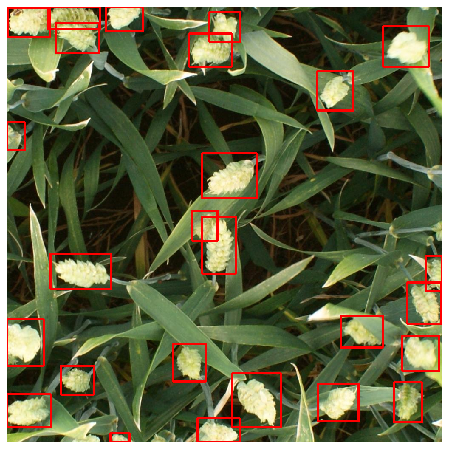

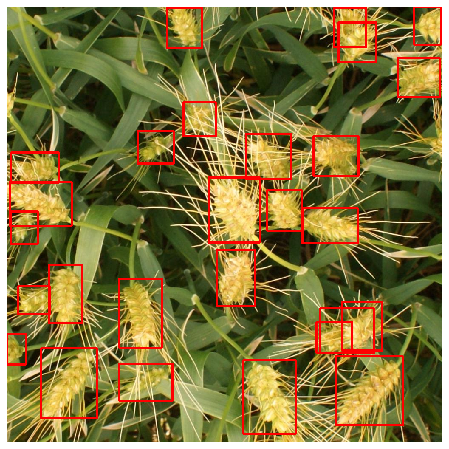

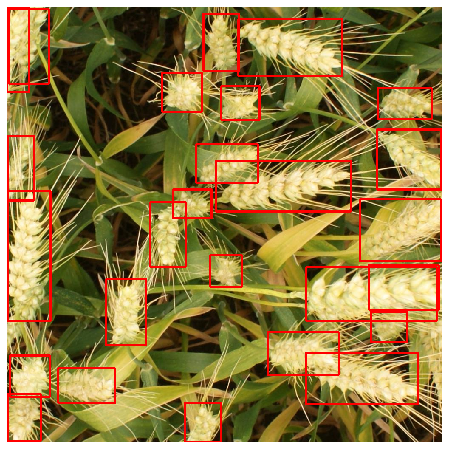

In [20]:
for image_id, pred_str in zip(sub_df.iloc[:3]['image_id'], sub_df.iloc[:3]['PredictionString']):
    image_path = os.path.join(DATA_DIR, 'test', f'{image_id}.jpg')
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    boxes = get_bboxes(pred_str)
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2] + box[0], box[3] + box[1]),
                      (255, 0, 0), 3)

    ax.set_axis_off()
    ax.imshow(image)
    plt.show()